## AI models for classifying pharmacy patients according to adherence level

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [34]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score
# Import supplementary visualization code visuals.py
import visuals as vs
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")




# Success - Display the first record
display(data.head(n=5))
#type(data)// ------------------------

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,MPR
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,Low MPR
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,Low MPR
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,Low MPR
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,Low MPR
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,Low MPR


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals having High MPR. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals having HIGH MPR, `'High MPR'`.
- The number of individuals having Low MPR, `'Low MPR'`.
- The percentage of individuals having High MPR, `'greater_percent'`. 

In [13]:
#Total number of records
n_records = data.age.count()# -------------------------------------------
# OR 
#print(data['age'].count())-------------------------------------------

#Number of records where individual having High MPR
high_mpr = data[data.MPR=="High MPR"].MPR.count()


# TODO: Number of records where individual having Low MPR
low_mpr =  data[data.MPR=="Low MPR"].MPR.count()

# TODO: Percentage of individuals having High MPR
greater_percent = round((high_mpr/n_records)*100,2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals having High MPR: {}".format(high_mpr))
print("Individuals having Low MPR: {}".format(low_mpr))
print("Percentage of individuals having High MPR: {}%".format(greater_percent))

Total number of records: 45222
Individuals having High MPR: 11208
Individuals having Low MPR: 34014
Percentage of individuals having High MPR: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

D:\College Project\Donors-for-charityML-master1\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


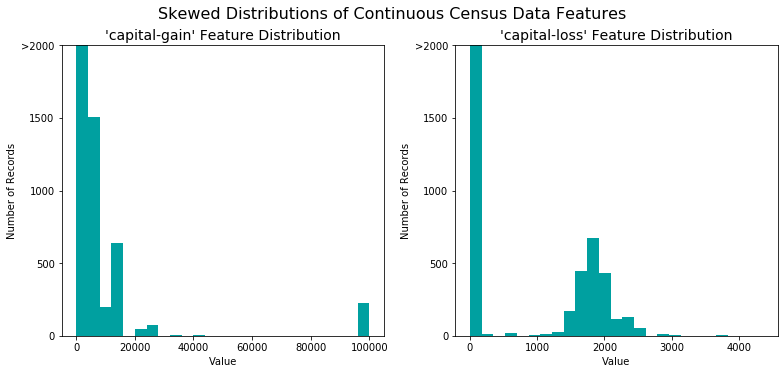

In [14]:
# Split the data into features and target label
#income_raw == MPR_raw
MPR_raw = data['MPR']
features_raw = data.drop('MPR', axis = 1)

#vs.distribution(income_raw)

# Visualize skewed continuous features of original data
vs.distribution(data)


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

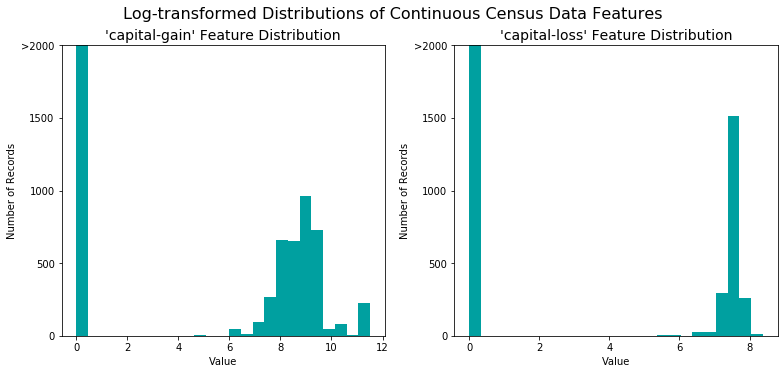

In [15]:
# Log-transform the skewed features
#print(features_raw[skewed])

skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))
#print(features_log_transformed[skewed])

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [16]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
#print(features_log_minmax_transform)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [17]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)
#print(features_final) #// unhash this command to see the features after one-hot encoding-------------

# TODO: Encode the 'MPR_raw' data to numerical values
MPR = MPR_raw.apply(lambda x : 1 if x =='High MPR' else 0)
#print(income)  #// unhash to see the  result --------------------------------------
#print(features_final)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print(" {}total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)


 103total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [19]:
# Import train_test_split
from sklearn.model_selection  import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    MPR, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0])) #shape[0] it checks no of rows
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 36177 samples.
Testing set has 9045 samples.


## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

# Metrics and the Naive Predictor
*As as business problem*, we want to know individuals that have **Low MPR**, and are most likely to secede there prescribed Rx. Because of this, we are interested in predicting who have **Low MPR**. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that having **high MPR** is someone who does would be detrimental to **Pharmacy**, since they are looking to find individuals willing to secede there medicine. Therefore, a model's ability to precisely predict those have **Low MPR** is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual having **High MPR**, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [20]:
'''
TP = np.sum(MPR) # Counting the ones as this is the naive case. Note that 'MPR' is the 'MPR_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = ( MPR.count()-TP ) # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

'''
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

MPR_pred=MPR.apply(lambda x:1)


TP=sum(map(lambda x,y: 1 if x==1 and y==1 else 0, MPR,MPR_pred)) #True Pos
FP=sum(map(lambda x,y: 1 if x==0 and y==1 else 0, MPR,MPR_pred)) #False Pos
FN=sum(map(lambda x,y: 1 if x==1 and y==0 else 0, MPR,MPR_pred)) #False Neg

# accuracy = TP/(TP+FP)
accuracy = float(TP)/(TP+FP)

# The commented code below was used to confirm the precision calculation was correct
#accuracy1 = accuracy_score(MPR,MPR_pred)
#print 'accuracy comparison',accuracy,accuracy1

#recall = TP/(TP+FN)
recall=float(TP)/(TP+FN)

# The commented code below was used to confirm the recall calculation was correct
#recal1=recall_score(MPR,MPR_pred)
#print 'recall comparison',recal1,recall1

# TODO: Calculate F-score using the formula above for beta = 0.5
beta=0.5
fscore = (1+beta**2)*((accuracy*recall)/(beta**2*accuracy+recall))

#fscore1=fbeta_score(income,income_pred, beta=0.5)
#print 'fscore comparison',fscore,fscore1

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **


This model has been applied to the stock market to forecast movement of different markets, and found to work well in markets with either high volatility or lower volatility[6]. In this case, Support Vector Machines were chosen because they tend to outperform other methods for financial time-series forecasting.
**Strengths**: Support Vector Machines perform well when there is a definite distinction between two classes
Fast training speed
Good for feature-intense data, e.g. text

**Weaknesses**: Support Vector Machines perform badly when the classification problem is not binary
Doesn't take into account all data equally, so can't see overall trends in data
A good choice in kernel is required, which is not always clear
Slow in test phase


**Applicability**:
Considering we have a binary classification - above or below $50k earnings - Support Vector Machines become a good candidate as a model. They're able to fit data well using the kernel trick and produce accurate results.

**K-nearest neighbors algorithm (k-NN)** is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression.In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small)https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

**Strengths**:
Simple to implement
Flexible to feature / distance choices
Naturally handles multi-class cases
Can do well in practice with enough representative data
It gets fitted to data in very less time and gives high accuracy and f_score on traning data.

**weekness**:
Large search problem to find nearest neighbours
It takes a alot of time in predicting the large data sets.

**Applicability**
This model is acceptable, as data is binary and there are large number of similar type of candidate which easily get classified by distance.

**Logistic Regression**
the logistic model (or logit model) is a statistical model that is usually taken to apply to a binary dependent variable.
Logistic regression is used in various fields, including machine learning, most medical fields, and social sciences. For example, the Trauma and Injury Severity Score (TRISS).Here are a few applications used in real-world situations.

Marketing: A marketing consultant wants to predict if the subsidiary of his company will make profit, loss or just break even depending on the characteristic of the subsidiary operations.

Human Resources: The HR manager of a company wants to predict the absenteeism pattern of his employees based on their individual characteristic.

**Strengths**:
It is more robust: the independent variables don’t have to be normally distributed, or have equal variance in each group.
It predicts the new data more efficient than any other algorithm.
F_score is preety good among all algorithm.
It train the algorithm within some fraction of seconds.


**Weakness**
It requires much more data to achieve stable, meaningful results. 
Normally distributed error terms are not assumed.


**Applicability**
Outputs have a nice probabilistic interpretation, and the algorithm can be regularized to avoid overfitting. Logistic models can be updated easily with new data using stochastic gradient descent.










### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [21]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: MPR training set
       - X_test: features testing set
       - y_test: MPR testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:],training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta = 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 361 samples.
SVC trained on 3617 samples.


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


D:\College Project\Donors-for-charityML-master1\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


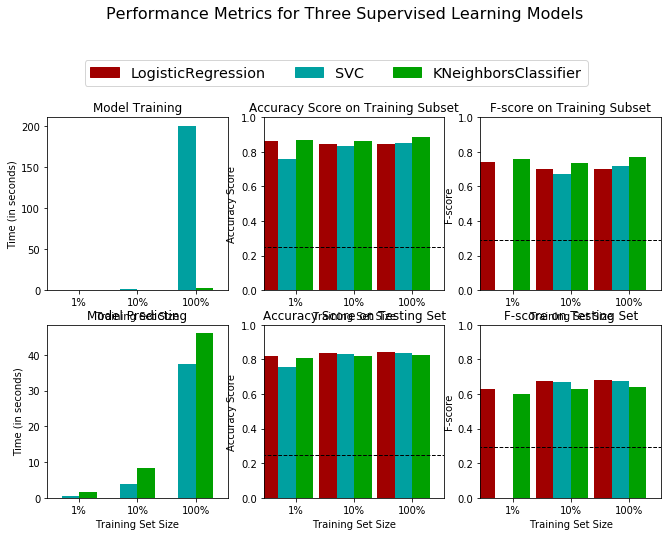

In [24]:
# TODO: Import the three supervised learning models from sklearn

# TODO: Initialize the three models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
clf_A = LogisticRegression(random_state=0)
clf_B = SVC(random_state = 0)
clf_C = KNeighborsClassifier(n_neighbors=5)
# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
def get_sample_size(percentage):
    return int((float(percentage)/100)*X_train.shape[0])

samples_1 = get_sample_size(1.0)
samples_10 = get_sample_size(10.0)
samples_100 = get_sample_size(100.0)
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 


Based on the evaluation you performed earlier, in one to two paragraphs, which of the three models you believe to be most appropriate for the task of identifying individuals have **High MPR**.
While considering all the points, the best model is LogisticRegression. The model gets trained on 100% data in very less time  as well as predict the data very quickly comparatively to others. The best point to choose this model because of F-score and accuracy score, both are high in this model.
Regardless of size, this model stands out in all ways. 
SVM did the almost the same job, but it lacks behind in traning and predicting time.
If we look at the huge data set, despite og large data sets, logistic regression gives its best results.


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [26]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Initialize the classifier
clf = LogisticRegression()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'solver':['newton-cg','lbfgs'], 'max_iter':[10,100,200,300]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)
# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,parameters,scoring= scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the numb

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8418
Final F-score on the testing data: 0.6829


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8418       |     0.8418      |
| F-score        |      0.6829       |    0.6829       |


**Answer:**
Accuracy and F-score for optimized model is 0.8418 and 0.6829. These scores are similar to the unoptimized model.
If we compare the result from optimized model then there is a huge difference as optimized one is a way better option than naive predictor


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [37]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = pl.figure(figsize = (9,10))
    pl.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(10), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    #pl.tight_layout()
    pl.show()  

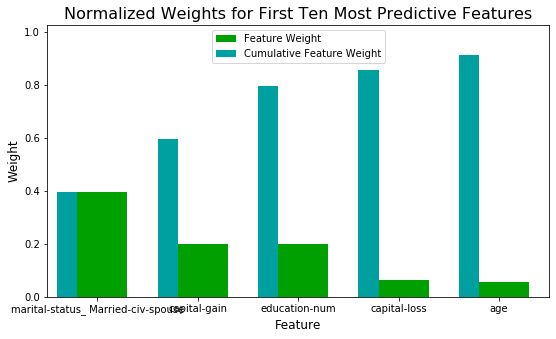

In [44]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import GradientBoostingClassifier


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model =GradientBoostingClassifier()
model.fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_
# Plot
feature_plot(importances, X_train, y_train)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [30]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8418
F-score on testing data: 0.6829

Final Model trained on reduced data
------
Accuracy on testing data: 0.8284
F-score on testing data: 0.6521




|     Metric     |   Benchmark model | Unoptimized Model | Optimized Model    | Reduced features Model | 
| :------------: | :---------------: | :-------------:   | :------------:     | :--------------------: |
| Accuracy Score |    0.2478         |    0.8418         |   0.8418           |      0.8284            |
| F-score        |    0.2917         |    0.6829         |   0.6829           |      0.6521            |

As expected, reducing the number of features has a negative impact upon our model. The optimized model has dropped in accuracy by around 1.59%, and the F-Score has dropped by around 4.5%. 

It depends on the algorithm that how much time it will take to fit the data.Time constraint is a big challange, if i go for SVM then definately i will choose reduced features data set because SVM takes a alot of time for fitting the data. But if there is case of using Logistic regression, i will preffer to choose actual dataset.
